In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")

# Path to the raw AEMET data directory
RAW_AEMET_DIR = os.path.abspath("../data/raw/aemet")

dfs = []
for fname in os.listdir(RAW_AEMET_DIR):
    if fname.endswith(".csv"):
        df = pd.read_csv(os.path.join(RAW_AEMET_DIR, fname))
        dfs.append(df)

meteo = pd.concat(dfs, ignore_index=True)

# Parse dates and convert numeric columns
meteo["fecha"] = pd.to_datetime(meteo["fecha"], errors="coerce")

num_cols = ["tmin","tmax","tmed","prec","sol","hrMedia","presMax","presMin"]
for col in num_cols:
    if col in meteo.columns:
        meteo[col] = pd.to_numeric(meteo[col], errors="coerce")

meteo = meteo.dropna(subset=["fecha"])
meteo["year"] = meteo["fecha"].dt.year

meteo.head()


,fecha,indicativo,nombre,provincia,altitud,tmed,prec,tmin,horatmin,tmax,...,presMax,horaPresMax,presMin,horaPresMin,hrMedia,hrMax,horaHrMax,hrMin,horaHrMin,year
0,1980-01-01,76,BARCELONA AEROPUERTO,BARCELONA,4.0,11.7,0.0,7.2,04:55,16.2,...,1015.7,00,1008.5,15,70.0,NaN,NaN,NaN,NaN,1980
1,1980-01-02,76,BARCELONA AEROPUERTO,BARCELONA,4.0,11.5,0.0,7.8,Varias,15.2,...,1022.8,24,1009.1,Varias,69.0,NaN,NaN,NaN,NaN,1980
2,1980-01-03,76,BARCELONA AEROPUERTO,BARCELONA,4.0,8.7,0.0,3.0,23:50,14.4,...,1024.7,12,1022.5,24,77.0,NaN,NaN,NaN,NaN,1980
3,1980-01-04,76,BARCELONA AEROPUERTO,BARCELONA,4.0,8.1,0.0,2.4,05:00,13.8,...,1022.5,00,1016.8,24,77.0,NaN,NaN,NaN,NaN,1980
4,1980-01-05,76,BARCELONA AEROPUERTO,BARCELONA,4.0,8.6,NaN,4.2,04:00,13.0,...,1017.7,Varias,1015.3,Varias,70.0,NaN,NaN,NaN,NaN,1980


In [12]:
# Filter years with at least 200 days of data
valid_years = (
    meteo.groupby(["nombre", "year"])["tmin"]
    .count()
    .reset_index(name="n_days")
)

valid_years = valid_years[valid_years["n_days"] >= 200]

meteo_clean = meteo.merge(valid_years[["nombre","year"]], on=["nombre","year"])

meteo_clean.head()


,fecha,indicativo,nombre,provincia,altitud,tmed,prec,tmin,horatmin,tmax,...,presMax,horaPresMax,presMin,horaPresMin,hrMedia,hrMax,horaHrMax,hrMin,horaHrMin,year
0,1980-01-01,76,BARCELONA AEROPUERTO,BARCELONA,4.0,11.7,0.0,7.2,04:55,16.2,...,1015.7,00,1008.5,15,70.0,NaN,NaN,NaN,NaN,1980
1,1980-01-02,76,BARCELONA AEROPUERTO,BARCELONA,4.0,11.5,0.0,7.8,Varias,15.2,...,1022.8,24,1009.1,Varias,69.0,NaN,NaN,NaN,NaN,1980
2,1980-01-03,76,BARCELONA AEROPUERTO,BARCELONA,4.0,8.7,0.0,3.0,23:50,14.4,...,1024.7,12,1022.5,24,77.0,NaN,NaN,NaN,NaN,1980
3,1980-01-04,76,BARCELONA AEROPUERTO,BARCELONA,4.0,8.1,0.0,2.4,05:00,13.8,...,1022.5,00,1016.8,24,77.0,NaN,NaN,NaN,NaN,1980
4,1980-01-05,76,BARCELONA AEROPUERTO,BARCELONA,4.0,8.6,NaN,4.2,04:00,13.0,...,1017.7,Varias,1015.3,Varias,70.0,NaN,NaN,NaN,NaN,1980


In [13]:
# Calculate annual mean of presMax and presMin
annual_press = (
    meteo_clean
    .groupby(["nombre", "year"], as_index=False)
    .agg({
        "presMax": "mean",
        "presMin": "mean"
    })
)

annual_press.head()


,nombre,year,presMax,presMin
0,BARCELONA AEROPUERTO,1980,1017.789344,1013.542623
1,BARCELONA AEROPUERTO,1981,1018.113151,1013.783014
2,BARCELONA AEROPUERTO,1982,1018.561918,1014.308493
3,BARCELONA AEROPUERTO,1983,1019.269315,1015.221918
4,BARCELONA AEROPUERTO,1984,1017.714481,1013.280055


In [14]:
# Function to plot pressure trends
def plot_press_trend(df, station_name):
    data = df[df["nombre"] == station_name].dropna(subset=["presMax","presMin"]).sort_values("year")
    
    if data.empty or len(data) < 3:
        print(f"⚠️ Not enough pressure data for {station_name}")
        return
    
    years = data["year"].values
    pmax = data["presMax"].values
    pmin = data["presMin"].values
    
    slope_max, intercept_max = np.polyfit(years, pmax, 1)
    slope_min, intercept_min = np.polyfit(years, pmin, 1)
    
    trend_max = slope_max * years + intercept_max
    trend_min = slope_min * years + intercept_min
    
    plt.figure(figsize=(9,4))
    plt.plot(years, pmax, label="Annual presMax", alpha=0.7)
    plt.plot(years, trend_max, "--", label=f"Trend presMax: {slope_max*10:.2f} hPa/decade")
    
    plt.plot(years, pmin, label="Annual presMin", alpha=0.7)
    plt.plot(years, trend_min, "--", label=f"Trend presMin: {slope_min*10:.2f} hPa/decade")
    
    plt.title(f"Annual Pressure — {station_name}")
    plt.xlabel("Year")
    plt.ylabel("Pressure (hPa)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
    
    print(f"📈 {station_name}")
    print(f"   presMax trend: {slope_max:.3f} hPa/year ({slope_max*10:.2f} hPa/decade)")
    print(f"   presMin trend: {slope_min:.3f} hPa/year ({slope_min*10:.2f} hPa/decade)")



--- BARCELONA, DRASSANES
⚠️ Not enough pressure data for BARCELONA, DRASSANES

--- BARCELONA, FABRA


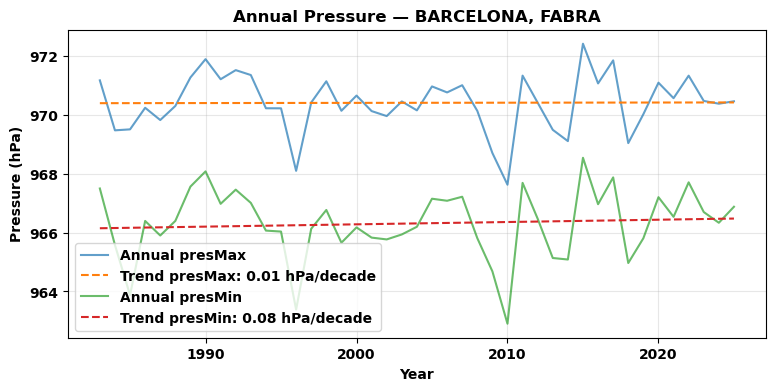

📈 BARCELONA, FABRA
   presMax trend: 0.001 hPa/year (0.01 hPa/decade)
   presMin trend: 0.008 hPa/year (0.08 hPa/decade)

--- BARCELONA AEROPUERTO


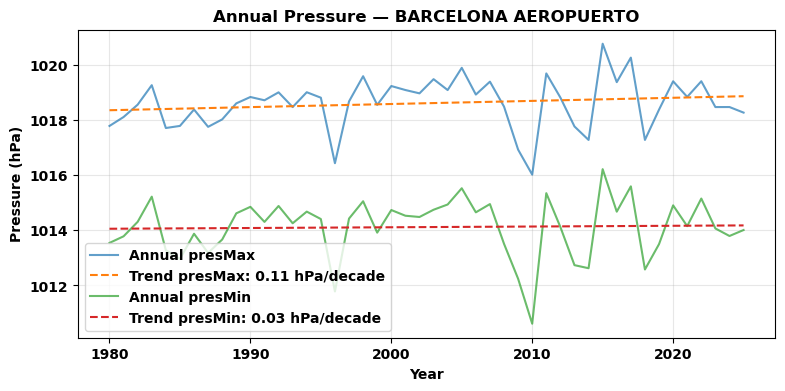

📈 BARCELONA AEROPUERTO
   presMax trend: 0.011 hPa/year (0.11 hPa/decade)
   presMin trend: 0.003 hPa/year (0.03 hPa/decade)

--- SABADELL AEROPUERTO


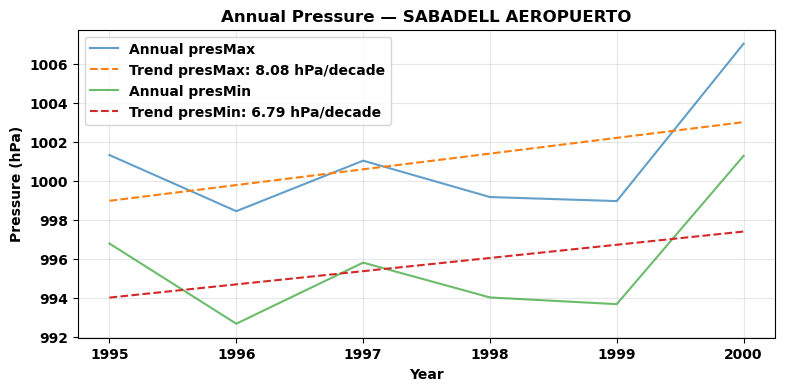

📈 SABADELL AEROPUERTO
   presMax trend: 0.808 hPa/year (8.08 hPa/decade)
   presMin trend: 0.679 hPa/year (6.79 hPa/decade)

--- MONTSERRAT
⚠️ Not enough pressure data for MONTSERRAT


In [15]:
# Stations
stations = [
    "BARCELONA, DRASSANES",
    "BARCELONA, FABRA",
    "BARCELONA AEROPUERTO",
    "SABADELL AEROPUERTO",
    "MONTSERRAT"
]

# Plot trends for each station
for st in stations:
    print("\n---", st)
    plot_press_trend(annual_press, st)

In [16]:
# Annual temps
annual_temp = (
    meteo_clean
    .groupby(["nombre","year"], as_index=False)
    .agg({
        "tmin": "mean",
        "tmax": "mean",
        "tmed": "mean"
    })
)
annual_temp["ATD"] = annual_temp["tmax"] - annual_temp["tmin"]

def compute_uhi(annual_df, urban_station, rural_station="MONTSERRAT"):
    urb = annual_df[annual_df["nombre"] == urban_station][["year","tmin"]].rename(columns={"tmin":"tmin_urb"})
    rur = annual_df[annual_df["nombre"] == rural_station][["year","tmin"]].rename(columns={"tmin":"tmin_rur"})
    merged = pd.merge(urb, rur, on="year", how="inner")
    merged["UHI"] = merged["tmin_urb"] - merged["tmin_rur"]
    merged["station"] = urban_station
    return merged

uhi_drassanes = compute_uhi(annual_temp, "BARCELONA, DRASSANES")
uhi_fabra = compute_uhi(annual_temp, "BARCELONA, FABRA")
uhi_bcn_airport = compute_uhi(annual_temp, "BARCELONA AEROPUERTO")
uhi_sabadell = compute_uhi(annual_temp, "SABADELL AEROPUERTO")


In [17]:
def merge_uhi_with_press(uhi_df, station_name):
    p_df = annual_press[annual_press["nombre"] == station_name][["year","presMax","presMin"]]
    return pd.merge(uhi_df, p_df, on="year", how="inner")
    
uhi_drassanes_p = merge_uhi_with_press(uhi_drassanes, "BARCELONA, DRASSANES")
uhi_fabra_p = merge_uhi_with_press(uhi_fabra, "BARCELONA, FABRA")
uhi_bcn_airport_p = merge_uhi_with_press(uhi_bcn_airport, "BARCELONA AEROPUERTO")
uhi_sabadell_p = merge_uhi_with_press(uhi_sabadell, "SABADELL AEROPUERTO")


In [20]:
from scipy.stats import pearsonr

def scatter_uhi_press(df, station_label, col, col_label):
    # Limpiar datos
    df = df.dropna(subset=[col, "UHI"])
    n = len(df)
    
    if n == 0:
        print(f"⚠️ Not enough pressure data for {station_label} (n=0). Skipping plot.")
        return
    if n < 5:
        print(f"⚠️ Few years for {station_label} (n={n}) – interpret with caution.")
    
    x = df[col]
    y = df["UHI"]
    
    # Si hay menos de 2 puntos, no podemos calcular r
    if n < 2:
        print(f"⚠️ Cannot compute Pearson r for {station_label} (need ≥2 points, got {n}).")
        return
    
    # Correlación de Pearson
    r, p = pearsonr(x, y)

    # Plot
    plt.figure(figsize=(6,4))
    sns.regplot(
        x=x, y=y,
        scatter_kws={"s": 45},
        line_kws={"color": "purple", "linewidth": 2}
    )

    plt.title(f"UHI vs {col_label} — {station_label}")
    plt.xlabel(col_label)
    plt.ylabel("UHI (°C)")
    plt.grid(True, alpha=0.3)

    stats_text = f"r = {r:.2f}\np = {p:.3f}"
    plt.gca().text(
        0.05, 0.05,                  
        stats_text,
        transform=plt.gca().transAxes,
        fontsize=10,
        verticalalignment="bottom",
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="gray")
    )

    plt.show()


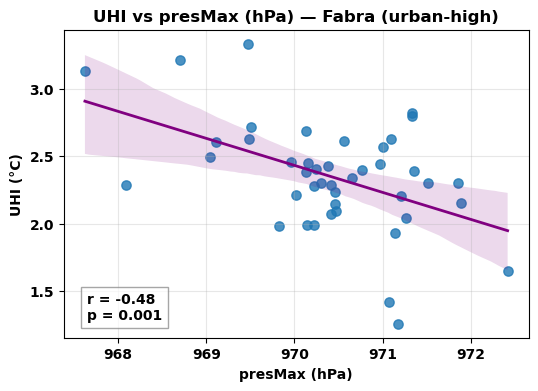

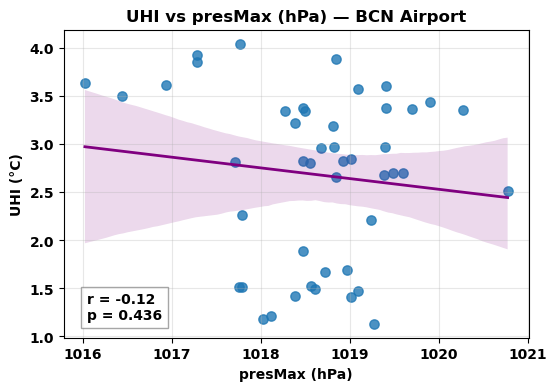

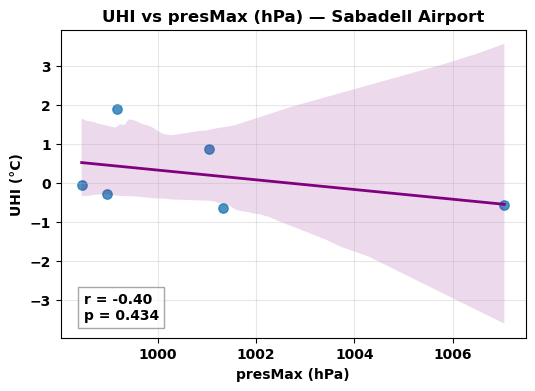

⚠️ Not enough pressure data for Drassanes (urban core) (n=0). Skipping plot.


In [22]:
scatter_uhi_press(uhi_fabra_p, "Fabra (urban-high)", "presMax", "presMax (hPa)")
scatter_uhi_press(uhi_bcn_airport_p, "BCN Airport", "presMax", "presMax (hPa)")
scatter_uhi_press(uhi_sabadell_p, "Sabadell Airport", "presMax", "presMax (hPa)")

# No data but kept for consistency
scatter_uhi_press(uhi_drassanes_p, "Drassanes (urban core)", "presMax", "presMax (hPa)")


“La presión atmosférica solo se analiza en las estaciones que disponen de este registro (Fabra, Aeropuerto de Barcelona y Aeropuerto de Sabadell). En el caso de Montserrat y Barcelona Drassanes, los ficheros de AEMET no incluyen presión máxima/mínima, por lo que estas estaciones quedan excluidas del análisis de presión.”

🔵 BCN Airport

r = −0.12 | p = 0.436 (no significativo)

Qué dice el gráfico

Pendiente ligeramente negativa

Nube de puntos muy dispersa

Línea de regresión casi plana

Interpretación

En el Aeropuerto de Barcelona la presión no controla la UHI de forma clara.

Esto es coherente porque:

fuerte influencia marítima (brisas, humedad)

atmósfera muy ventilada

la estabilidad anticiclónica se rompe fácilmente por circulaciones locales

👉 Aquí, aunque haya alta presión:

la energía no se queda “atrapada”

el enfriamiento nocturno sigue siendo relativamente eficiente

✅ Resultado esperado, correcto y físicamente lógico.

🟣 Fabra (urban-high)

r = −0.48 | p = 0.001 (significativo)

Qué dice el gráfico

Pendiente claramente negativa

Nube de puntos bien alineada

Relación robusta y significativa

Interpretación CLAVE

En Fabra:

A mayor presión → menor UHI

Esto puede parecer contraintuitivo si se piensa solo en estabilidad, pero encaja perfectamente cuando juntas todas las piezas:

Alta presión → cielos despejados

Cielos despejados → más enfriamiento radiativo nocturno

Fabra está elevada y bien ventilada

Resultado → Tmin baja → UHI más débil

🔁 Es el mismo mecanismo que ya viste con insolación y ATD.

👉 En esta estación:

domina el enfriamiento nocturno radiativo

más que la acumulación de calor diurna

Este resultado es muy potente y muestra coherencia interna del estudio.

🟠 Sabadell Airport

r = −0.40 | p = 0.434 (no significativo)

Qué dice el gráfico

Tendencia negativa

Intervalo de confianza enorme

Muy pocos puntos (poca potencia estadística)

Interpretación

En Sabadell el signo es interesante, pero:

hay muy pocos años con presión válida

la correlación no es estadísticamente significativa

Climatológicamente podría ocurrir:

alta presión → inversión térmica → UHI fuerte
pero con tan pocos datos no se puede afirmar.

✅ Lo correcto es:

reconocer el patrón,
pero no sacarle conclusiones firmes.

Esto demuestra rigor metodológico.

| Estación    | Efecto de la presión sobre la UHI |
| ----------- | --------------------------------- |
| BCN Airport | Sin efecto claro                  |
| Fabra       | **Mayor presión → menor UHI**     |
| Sabadell    | Tendencia débil, no concluyente   |


The relationship between atmospheric pressure and UHI intensity shows marked spatial variability.
At Barcelona Airport, no statistically significant correlation is observed, reflecting the dominant influence of maritime ventilation.
In contrast, Fabra exhibits a significant negative correlation (r = −0.48, p < 0.01), indicating that high-pressure conditions enhance clear-sky nocturnal radiative cooling in this elevated urban environment, leading to weaker UHI intensity.
At Sabadell Airport, a negative tendency is observed, but the limited number of years prevents robust statistical inference.